## Part 2 : REINFORCE algorithm

In [1]:
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

We will now apply the REINFORCE algorithm to the Acrobot environment.

## Description

The system consists of two links connected linearly to form a chain, with one end of the chain fixed. The joint between the two links is actuated. The goal is to apply torques on the actuated joint to swing the free end of the linear chain above a given height while starting from the initial state of hanging downwards.

## Action Space
The action is discrete, deterministic, and represents the torque applied on the actuated joint between the two links.

    | Num | Action                                | Unit         |
    |-----|---------------------------------------|--------------|
    | 0   | apply -1 torque to the actuated joint | torque (N m) |
    | 1   | apply 0 torque to the actuated joint  | torque (N m) |
    | 2   | apply 1 torque to the actuated joint  | torque (N m) 

## Observation Space
The observation is a ndarray with shape (6,) that provides information about the two rotational joint angles as well as their angular velocities.

    | Num | Observation                  | Min                 | Max               |
    |-----|------------------------------|---------------------|-------------------|
    | 0   | Cosine of `theta1`           | -1                  | 1                 |
    | 1   | Sine of `theta1`             | -1                  | 1                 |
    | 2   | Cosine of `theta2`           | -1                  | 1                 |
    | 3   | Sine of `theta2`             | -1                  | 1                 |
    | 4   | Angular velocity of `theta1` | ~ -12.567 (-4 * pi) | ~ 12.567 (4 * pi) |
    | 5   | Angular velocity of `theta2` | ~ -28.274 (-9 * pi) | ~ 28.274 (9 * pi) |

where

theta1 is the angle of the first joint, where an angle of 0 indicates the first link is pointing directly downwards.

theta2 is relative to the angle of the first link. An angle of 0 corresponds to having the same angle between the two links.

The angular velocities of theta1 and theta2 are bounded at ±4π, and ±9π rad/s respectively. A state of [1, 0, 1, 0, ..., ...] indicates that both links are pointing downwards.

## Rewards
The goal is to have the free end reach a designated target height in as few steps as possible, and as such all steps that do not reach the goal incur a reward of -1. Achieving the target height results in termination with a reward of 0. The reward threshold is -100.

## Starting State
Each parameter in the underlying state (theta1, theta2, and the two angular velocities) is initialized uniformly between -0.1 and 0.1. This means both links are pointing downwards with some initial stochasticity.

## Episode End
The episode ends if one of the following occurs:

1. Termination: The free end reaches the target height, which is constructed as: -cos(theta1) - cos(theta2 + theta1) > 1.0

2. Truncation: Episode length is greater than 500 

We can now load the environment and see the shape of the possible actions and state :

In [2]:
env = gym.make('Acrobot-v1')
n_actions = env.action_space.n
shape_states = env.observation_space.shape

For the initial policy of our REINFORCE algorithm, we will use a softmax-based policy : .
$$ softmax(z)_i = \frac{e^{z_i}}{\sum_{j=1}^3 e^{z_j}}, $$
with $$ z = \theta^T x.$$

For an action $a_t$, we have the policy
$$ \pi(a_t | x_t, \theta) = softmax(\theta^T x) $$

We will also compute the gradient of the logarithm of the policy (gradient of a composite function), for a given action $a_t$ : 
$$ \nabla log(\pi(a_t | x_t)) = \frac{\nabla_\theta \pi(a_t | x_t)}{\pi_\theta(a_t|x_t)} $$

In [4]:
# Functions

def softmax(x):
    #softmax function
    y = np.exp(x)
    return y/y.sum()  

def policy(state,theta):
    #returns a vector of size 3 containing the probability to do each action 0,1 and 2 according to our chosen policy
    return softmax(state.dot(theta))

def gradient_function(softmax):
    #returns an array of size (3,3)
    #the argument softmax is the vector of the policy for a given state and theta
    s = softmax.reshape(-1,1)
    return np.diagflat(s) - np.dot(s, s.T) 

We use the following REINFORCE algorithm :

In [5]:
# REINFORCE Algorithm

def reinforce(theta_0,lr,n_episode):
    env = gym.make("Acrobot-v1")
    theta = theta_0
    History = [] #list of the final reward for each n_episode simulated episode
    
    for i in range(n_episode):
        X = [] #list of states
        A = [] #list of actions
        R = [] #list of rewards
        Grad = [] #list of gradients
        x = env.reset()[0][None,:] #initial state
        n_move = 0 #number of moved in the simulated episode
        terminated = False
        truncated = False
        
        while not terminated and not truncated: #episode to fill the lists
            n_move += 1 
            
            pol = policy(x, theta) #pol[0] is an array containing the policy for each action
            action = np.random.choice(3, p=pol[0])
           
            gradsoftmax = gradient_function(pol)[action,:] # line vector of size 3
            gradlog = gradsoftmax / pol[0,action] # line vector of size 3
            grad = x.T.dot(gradlog[None,:]) # x is the state and a common factor in the gradient of the log policy
            #grad is now the gradient of the log policy, a matrix of size (6,3)
            Grad.append(grad)
            
            x_new, r, terminated, truncated, info = env.step(action)
            
            R.append(r)
            X.append(x)
            A.append(action)
            
            x = x_new[None,:] 
        
        History.append(np.sum(R)) # We add to History the total reward, equal to -n_move
        
        for n in range(n_move): #list run for the adjustment of theta
            Rewardstot=np.cumsum(R[n:])
            G=Rewardstot[-1]
            theta += lr*G*Grad[n] # adjustment of theta for gamma = 1
    
    #env.close()
    return theta, History

We will use the following parameters to test our algorithm :

In [7]:
# Parameters

lr = 0.0001 #the learning rate
n_episode = 500 #the number of episodes to simulate
U = np.random.uniform(-0.1,0.1,18)
theta_0 = U.reshape((6,3)) #the initial theta, of size (6,3), with random coefficients found in [-0,1, 0,1]

We run the algorithm :

In [8]:
theta_opt, History = reinforce(theta_0,lr,n_episode)

In [10]:
History

[-500.0,
 -175.0,
 -140.0,
 -253.0,
 -219.0,
 -359.0,
 -500.0,
 -412.0,
 -500.0,
 -325.0,
 -407.0,
 -141.0,
 -162.0,
 -141.0,
 -165.0,
 -193.0,
 -182.0,
 -306.0,
 -228.0,
 -250.0,
 -221.0,
 -249.0,
 -172.0,
 -207.0,
 -137.0,
 -161.0,
 -205.0,
 -144.0,
 -195.0,
 -166.0,
 -144.0,
 -196.0,
 -139.0,
 -207.0,
 -149.0,
 -160.0,
 -171.0,
 -240.0,
 -172.0,
 -173.0,
 -171.0,
 -180.0,
 -165.0,
 -181.0,
 -162.0,
 -169.0,
 -164.0,
 -318.0,
 -153.0,
 -143.0,
 -148.0,
 -146.0,
 -153.0,
 -206.0,
 -122.0,
 -156.0,
 -172.0,
 -225.0,
 -160.0,
 -150.0,
 -138.0,
 -259.0,
 -173.0,
 -140.0,
 -94.0,
 -108.0,
 -128.0,
 -134.0,
 -109.0,
 -122.0,
 -178.0,
 -134.0,
 -107.0,
 -146.0,
 -119.0,
 -139.0,
 -102.0,
 -125.0,
 -92.0,
 -105.0,
 -173.0,
 -80.0,
 -125.0,
 -82.0,
 -192.0,
 -144.0,
 -133.0,
 -122.0,
 -163.0,
 -115.0,
 -115.0,
 -119.0,
 -99.0,
 -118.0,
 -100.0,
 -500.0,
 -84.0,
 -118.0,
 -98.0,
 -100.0,
 -287.0,
 -102.0,
 -97.0,
 -105.0,
 -77.0,
 -89.0,
 -81.0,
 -101.0,
 -84.0,
 -117.0,
 -89.0,
 -80.0,
 -119.

We will now graphically represent the results :

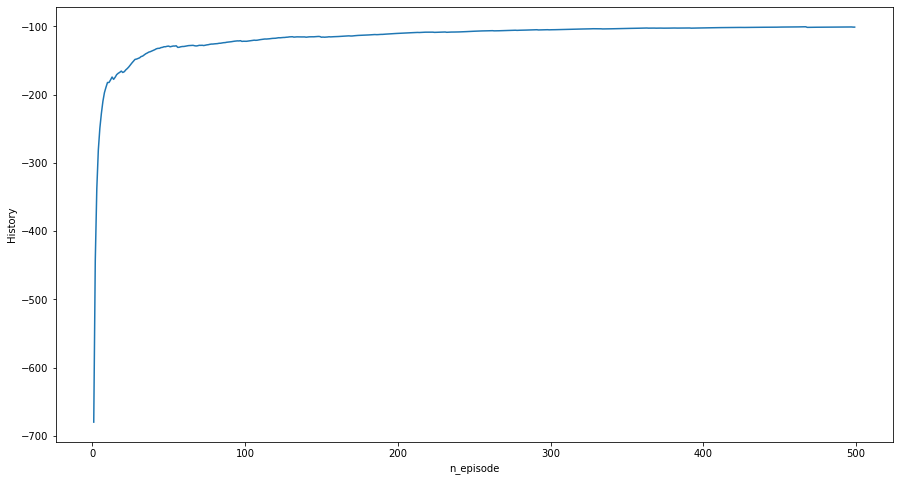

In [477]:
# Visualisation

fig, axes = plt.subplots(figsize=(15, 8))
plt.plot(np.arange(len(History)), np.cumsum(History)/np.arange(len(History)))
plt.title('Evolution of the reward for each step of the REINFORCE algorithm)
plt.ylabel('History')
plt.xlabel('n_episode')
plt.show()

In conclusion, our REINFORCE algorithm manages to find an optimal parameter theta so that we can win the game in around 100 moves :

In [9]:
theta_opt

array([[ 0.30847402, -0.02461076, -0.30021091],
       [ 0.20718209, -0.57900301,  0.20506316],
       [ 0.79395235, -0.25201537, -0.43193513],
       [-0.20168437,  0.55453873, -0.38535434],
       [ 1.21402347, -0.07331369, -1.05770504],
       [-1.39871614,  0.16418025,  1.23171099]])

However, it takes a few hundreds of episode to converge, we noticed that the initial policy here is a key to improve the convergence of the algorithm. We did try to find other policies to use, like a sigmoid-based one, but we didn't manage to reach a convergent algorithm.